# Flows conditioned with deep sets

In [27]:
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from flax import linen as nn
import numpy as np
import optax
from neural_flow import Flow
from neural_flow.bijectors import ShiftBounds, RollingSplineCoupling
from neural_flow.utils import FeedForwardNetwork

# We generate some toy data, 1000 sets each with a size drawn from
# an exponential distribution. The maximum size is fixed to 400.
# Each set has elements which are vectors of size two.
rng = np.random.default_rng(1)


def generate(rng, size):
    n = rng.exponential(size=size)
    n *= 400 / np.max(n)
    n += 1  # ensure there are no empty sets
    n = n.astype(int)

    # The mapping to learn is a non-linear function of the inputs. One can also
    # replace np.mean with np.max or np.sum.
    def true_mapping(x):
        return len(x) ** 0.5

    X = [np.array(rng.normal(size=(ni, 2))) for ni in n]
    ym = [true_mapping(x) for x in X]
    y = rng.normal(ym, 1, size=(2, len(ym))).T

    return X, ym, y


def preprocess(X, y, padded_X_size):
    """
    Concatenates the input sets and pads inputs and outputs to fixed sizes.

    Returns padded arrays, the summation matrix, and a mask to undo the padding.
    """
    n = [len(x) for x in X]
    assert padded_X_size >= np.sum(n)
    X = np.concatenate(X)
    X = np.concatenate([X, np.zeros((padded_X_size - len(X),) + X.shape[1:])])
    indices = np.empty((np.sum(n), 2), dtype=int)
    a = 0
    for j, b in enumerate(np.cumsum(n)):
        indices[a:b, 0] = j
        indices[a:b, 1] = np.arange(a, b)
        a = b
    sum_matrix = sparse.BCOO(
        (np.ones(len(indices), dtype=np.int8), indices),
        shape=(len(y), padded_X_size),
        indices_sorted=True,
        unique_indices=True,
    )
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y, sum_matrix


X_train, ym_train, y_train = generate(rng, 1000)
ym_train = jnp.array(ym_train)
X_train, y_train, sum_train = preprocess(X_train, y_train, 50_000)

X_test, ym_test, y_test = generate(rng, 100)
ym_test = jnp.array(ym_test)
X_test, y_test, sum_test = preprocess(X_test, y_test, sum(len(x) for x in X_test))

In [33]:
class Phi(nn.Module):
    @nn.compact
    def __call__(self, x, sum_matrix, train: bool):
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = FeedForwardNetwork(8, 6, 128)(x)
        x = nn.Dropout(rate=0.3, deterministic=not train)(x)
        x = sum_matrix @ x
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = FeedForwardNetwork(1, 6, 128)(x)
        return x.reshape(-1)


phi = Phi()
root_key = jax.random.PRNGKey(0)
init_key, dropout_key = jax.random.split(root_key)

variables = phi.init(init_key, X_train, sum_train, train=False)
params = variables["params"]
batch_stats = variables["batch_stats"]

opt = optax.nadamw(learning_rate=1e-3)
opt_state = opt.init(params)


@jax.jit
def loss_fn(params, batch_stats, x, sum_matrix, y, dropout_key):
    yp, updates = phi.apply(
        {"params": params, "batch_stats": batch_stats},
        x,
        sum_matrix,
        train=True,
        mutable=["batch_stats"],
        rngs={"dropout": dropout_key},
    )
    return jnp.mean(optax.l2_loss(yp, y)), updates


@jax.jit
def step(params, batch_stats, opt_state, x, sum_matrix, y, dropout_key):
    grad, updates = jax.grad(loss_fn, has_aux=True)(
        params, batch_stats, x, sum_matrix, y, dropout_key
    )
    batch_stats = updates["batch_stats"]
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, batch_stats, opt_state


best_epoch = 0
best_params = params
loss_train = []
loss_test = []
patience = 100
for epoch in range(5000):
    dropout_train_key = jax.random.fold_in(dropout_key, data=epoch)
    params, batch_stats, opt_state = step(
        params, batch_stats, opt_state, X_train, sum_train, ym_train, dropout_train_key
    )
    loss_train.append(
        loss_fn(params, batch_stats, X_train, sum_train, ym_train, dropout_train_key)[0]
    )
    loss_test.append(
        loss_fn(params, batch_stats, X_test, sum_test, ym_test, dropout_train_key)[0]
    )
    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_params = params

    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_params = params

    stop = np.isnan(loss_train[-1]) or (
        len(loss_test) > 2 * patience
        and not np.min(loss_test[-patience:])
        < np.min(loss_test[-2 * patience : -patience])
    )

    if epoch % 10 == 0:
        print(
            f"epoch {epoch} loss[train] = {loss_train[-1]:10.2f} "
            f"loss[test] = {loss_test[-1]:10.2f}"
        )

    if stop:
        break

epoch 0 loss[train] =      22.62 loss[test] =      40.54
epoch 10 loss[train] =      10.49 loss[test] =      22.08
epoch 20 loss[train] =       7.10 loss[test] =      12.70
epoch 30 loss[train] =       4.76 loss[test] =      11.66
epoch 40 loss[train] =       3.11 loss[test] =       7.43
epoch 50 loss[train] =       2.10 loss[test] =       7.06
epoch 60 loss[train] =       1.36 loss[test] =       6.24
epoch 70 loss[train] =       0.90 loss[test] =       5.01
epoch 80 loss[train] =       0.46 loss[test] =       4.31
epoch 90 loss[train] =       0.24 loss[test] =       3.60
epoch 100 loss[train] =       0.16 loss[test] =       3.30
epoch 110 loss[train] =       0.12 loss[test] =       2.89
epoch 120 loss[train] =       0.08 loss[test] =       2.99
epoch 130 loss[train] =       0.07 loss[test] =       2.81
epoch 140 loss[train] =       0.06 loss[test] =       2.64
epoch 150 loss[train] =       0.05 loss[test] =       2.78
epoch 160 loss[train] =       0.04 loss[test] =       2.85
epoch 17

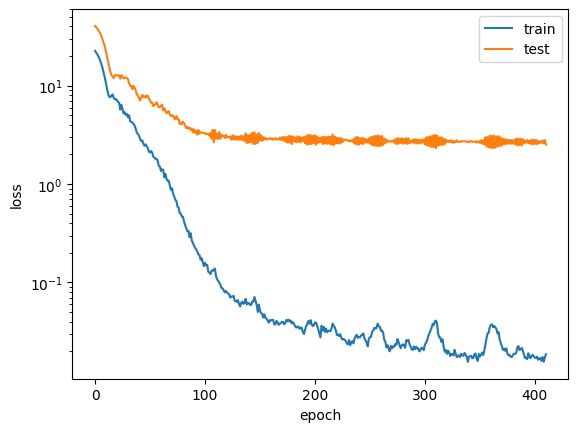

In [34]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.semilogy();

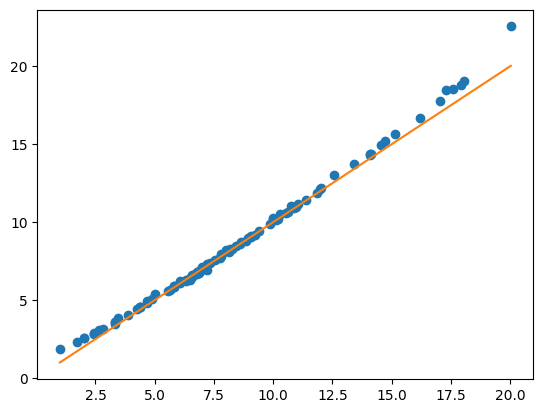

In [36]:
ym_pred = phi.apply(
    {"params": best_params, "batch_stats": batch_stats}, X_test, sum_test, train=False
)
plt.scatter(ym_test, ym_pred)
diag = [np.min(ym_test), np.max(ym_test)]
plt.plot(diag, diag, color="C1");

In [8]:
init_key = jax.random.PRNGKey(0)


flow = Flow(ShiftBounds(), RollingSplineCoupling(
    knots=4,
    make_network=lambda n: FeedForwardNetwork(n, 1, 16)))
phi = Phi()

params = {"phi": phi.init(init_key, X_train, sum_train)}

c_init = phi.apply(params["phi"], X_train, sum_train)
params["flow"] = flow.init(init_key, y_train, c_init)


@jax.jit
def loss_fn(params, y, x, sum_matrix):
    c = phi.apply(params["phi"], x, sum_matrix)
    return -np.mean(flow.log_prob(params["flow"], y, c))


opt = optax.nadamw(learning_rate=1e-3)
opt_state = opt.init(params)


@jax.jit
def step(params, opt_state, y, x, sum_matrix):
    grad = jax.grad(loss_fn)(params, y, x, sum_matrix)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state


best_epoch = 0
best_params = params
loss_train = []
loss_test = []
patience = 100
for epoch in range(5000):
    params, opt_state = step(params, opt_state, y_train, X_train, sum_train)
    loss_train.append(loss_fn(params, y_train, X_train, sum_train))
    loss_test.append(loss_fn(params, y_test, X_test, sum_test))
    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_params = params

    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_params = params

    stop = np.isnan(loss_train[-1]) or (
        len(loss_test) > 2 * patience
        and not np.min(loss_test[-patience:])
        < np.min(loss_test[-2 * patience : -patience])
    )

    print(f"epoch {epoch} {loss_train[-1]:.2f} {loss_test[-1]:.2f}")

    if stop:
        break

epoch 0 340282343469402359241130679742758912.00 inf
epoch 1 inf inf
epoch 2 inf inf
epoch 3 inf inf
epoch 4 inf inf
epoch 5 inf inf
epoch 6 inf inf
epoch 7 inf inf
epoch 8 inf inf
epoch 9 inf inf
epoch 10 inf inf
epoch 11 inf inf
epoch 12 inf inf
epoch 13 inf inf
epoch 14 inf inf
epoch 15 inf inf
epoch 16 inf inf
epoch 17 inf inf
epoch 18 inf inf
epoch 19 inf inf
epoch 20 inf inf
epoch 21 inf inf
epoch 22 inf inf
epoch 23 inf inf
epoch 24 inf inf
epoch 25 inf inf
epoch 26 inf inf
epoch 27 inf inf
epoch 28 inf inf
epoch 29 inf inf
epoch 30 inf inf
epoch 31 inf inf
epoch 32 inf inf
epoch 33 inf inf


KeyboardInterrupt: 

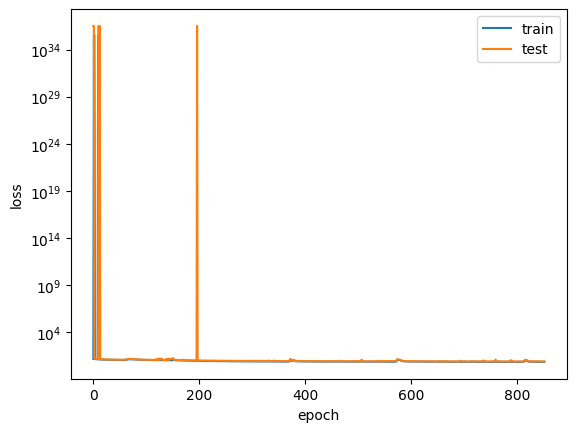

In [ ]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.semilogy();

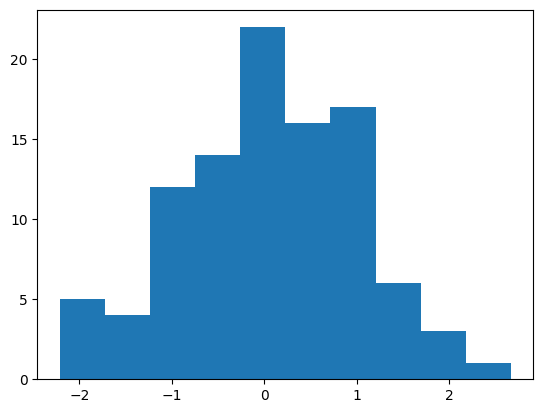

In [ ]:
plt.hist(y_test[:, 0] - np.array(ym_test));

[[-41.898514    -6.0243225 ]
 [ 29.026962    27.693863  ]
 [ 11.808746    23.00064   ]
 [ 36.578064    40.073334  ]
 [-29.096436   -12.390213  ]
 [ 20.38002     25.501266  ]
 [-32.36467    -14.358963  ]
 [-37.53572     -2.5087585 ]
 [ 22.818817    25.966537  ]
 [313.49146    287.5536    ]
 [293.81323    302.32504   ]
 [ 73.72111     71.44287   ]
 [ 50.82785     54.01378   ]
 [ 29.429367    33.1718    ]
 [ 12.635162    15.790329  ]
 [ 46.228073    48.450226  ]
 [ 70.39845     70.42735   ]
 [-48.22148    -11.591324  ]
 [ 35.097305    39.249878  ]
 [214.17546    171.79861   ]
 [ 52.97267     59.17148   ]
 [ -5.191498     6.5248413 ]
 [-25.13765     -7.2319183 ]
 [  3.5298767   12.602951  ]
 [-27.318344    -4.9248505 ]
 [-43.531784   -19.156418  ]
 [ 24.830612    26.454132  ]
 [-33.25676      1.4847565 ]
 [-40.053467   -18.609985  ]
 [ 52.96074     59.196426  ]
 [ 44.73282     40.02664   ]
 [ 50.017227    55.122818  ]
 [ 49.948135    46.037994  ]
 [ 44.70038     52.36653   ]
 [ 65.784164  

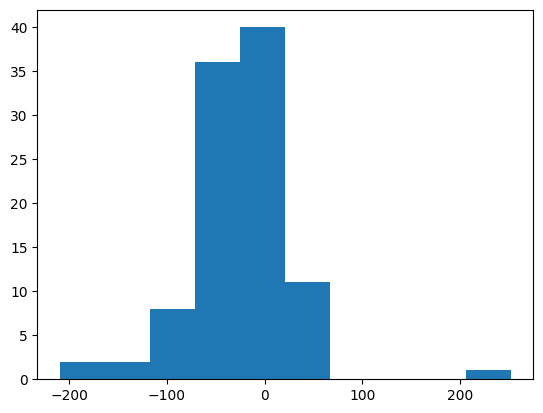

In [ ]:
c = phi.apply(params["phi"], X_test, sum_test)
y_pred = flow.sample(params["flow"], c)
print(y_pred)
plt.hist(y_pred[:, 0] - np.array(ym_test));